In [7]:

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import gymnasium as gym
import gym_bondgraph
from bond_graph import *
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%reload_ext autoreload
%autoreload 2

### Set up seed bond graph

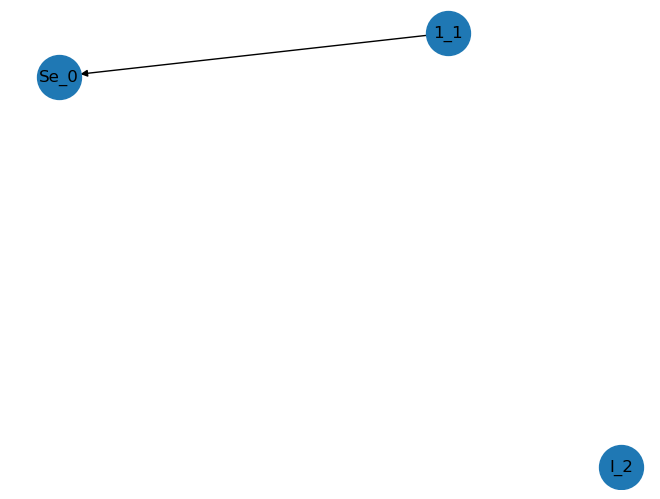

In [8]:
MAX_NODES = 8
MAX_STATES = 4

t_span = [0, 10]
time_array = np.linspace(t_span[0], t_span[1], 500)

s0 = BondGraph(max_nodes=MAX_NODES, max_states=MAX_STATES, time_array=time_array)
s0.add_element(EffortSource())
s0.add_element(OneJunction())
s0.add_bond(1, 0, -1)
s0.add_element(Inertance(1))

labels = nx.get_node_attributes(s0.flow_causal_graph, 'element_label')
nx.draw(s0.flow_causal_graph, labels=labels, with_labels=True, node_size=1000)


default_params = {
    'R': 1,
    'I': 1,
    'C': 1,
}
seed = np.random.randint(1,100)


In [9]:
env = gym.make('gym_bondgraph/BondGraphEnv-v4',  seed=None, seed_graph=s0, max_nodes=MAX_NODES, default_params=default_params)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Daniel\miniconda3\envs\bond-graph\lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (8, 8)
  logger.warn(


In [10]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

## Q-Network

In [11]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Training

In [14]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.flattened_action_space.shape[0]
print("n_actions: ", n_actions)
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print("n_observations: ", n_observations)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

n_actions:  35
n_observations:  3
